In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
current_path = os.getcwd().split("Model")[0]
from Model.ZEstimator.DistributionEstimation.ais_importance_weighted_ebm import AISZEstimator
from Model.Energy.Distribution.ExplicitBiasForDistribution import MockBias
from Model.Proposals.ProposalForDistributionEstimation.gaussian import Gaussian
from hydra_config import store_main
from hydra import compose, initialize_config_dir
from argparse import ArgumentParser

from Model.Proposals.mock_base_dist import MockBaseDist

import hydra


In [168]:
def clear_hydra():
    hydra.core.global_hydra.GlobalHydra.instance().clear()

def get_config(config_path = "conf_test", config_name = "config"):
    # Test for all prior distributions
    clear_hydra()
    store_main()
    print(current_path)
    initialize_config_dir(config_dir=os.path.join(current_path, config_path), job_name="test_app")
    # initialize(config_path=config_path, job_name="test_app")
    cfg = compose(config_name=config_name, overrides=[])
    return cfg

In [175]:
import torch.nn as nn
class stupid_f_theta(nn.Module):
    def __init__(self,):
        super(stupid_f_theta, self).__init__()   
        self.mean = nn.parameter.Parameter(torch.zeros(1,2))
        self.cov = nn.parameter.Parameter(torch.ones(1,2))
        dist_gaussian = torch.distributions.Normal(self.mean, self.cov)                    
        self.f_theta = lambda x: -dist_gaussian.log_prob(x)
    
    # def to(self, device):
        # self
    def forward(self, x):
        energy = self.f_theta(x).flatten(1).sum(-1,keepdim=True)
        return energy
        
class StupidProposal(nn.Module):
    def __init__(self):
        super(StupidProposal, self).__init__()
        self.mean = nn.parameter.Parameter(torch.full((1,2), 5.))
        self.cov = nn.parameter.Parameter(torch.ones(1,2))
        self.dist_gaussian = torch.distributions.Normal(self.mean, self.cov)
        self.dim = 2

    def sample(self, nb_sample, return_log_prob = False):
        if not return_log_prob :
            return self.dist_gaussian.sample((nb_sample,))
        else :
            samples = self.dist_gaussian.sample((nb_sample,))
            log_probs = self.dist_gaussian.log_prob(samples).flatten(1).sum(-1,keepdim=True)
            return samples, log_probs
        
    def log_prob(self, x):
        return self.dist_gaussian.log_prob(x).flatten(1).sum(-1,keepdim=True)

In [237]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


proposal_distribution = StupidProposal()
explicit_bias = MockBias()
base_dist= MockBaseDist()
f_theta = stupid_f_theta()

f_theta = f_theta.to(device)
proposal_distribution = proposal_distribution.to(device)
explicit_bias = explicit_bias.to(device)
base_dist = base_dist.to(device)



cfg = get_config()
print(cfg.train)

if torch.cuda.is_available():
    device = torch.device("cuda")
else :
    device = torch.device("cpu")
cfg.ebm.nb_transitions_ais = 4.0
cfg.ebm.step_size_ais = 1.0
nb_sample = 100



/scratch/project/dd-23-138/SelfNormalizedLikelihood


/tmp/ipykernel_69392/3062668526.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize_config_dir(config_dir=os.path.join(current_path, config_path), job_name="test_app")


{'trainer_name': 'self_normalized', 'max_steps': None, 'max_epochs': 100, 'output_folder': './Results', 'load_from_checkpoint': False, 'just_test': False, 'seed': 42, 'decay_ema': None, 'task': 'distribution_estimation', 'save_dir': None, 'multi_gpu': 'single', 'val_check_interval': None, 'save_energy_every': 1, 'samples_every': 1, 'sigma': None, 'entropy_weight': 0.0001, 'log_every_n_steps': 10, 'test_every': 1, 'save_locally': False, 'start_with_IS_until': 0, 'bias_training_iter': 0, 'lr_bias': 0.001, 'noise_annealing_init': 0.0, 'noise_annealing_gamma': 0.999, 'nb_energy_steps': 0, 'plot_contour_evolution': False}


ValidationError: Value '4.0' of type 'float' could not be converted to Integer
    full_key: ebm.nb_transitions_ais
    reference_type=BaseEBM
    object_type=BaseAISEBM

In [228]:
ebm = AISZEstimator(f_theta, proposal_distribution, base_dist, explicit_bias=explicit_bias, cfg_ebm=cfg.ebm)
ebm = ebm.to(device)

In [229]:

samples, log_prob = ebm.sample_ais(nb_sample, return_full_list=True, return_log_prob=True)
# print(ebm.explicit_bias)
# print(samples[0].shape)
# print(len(samples))
# # print((ebm.calculate_energy(samples[0], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[0]).logsumexp(0) - np.log(nb_sample))
# print((-f_theta(samples[0]).reshape(nb_sample,1) + base_dist.log_prob(samples[0]) - log_prob[0]).logsumexp(0) - np.log(nb_sample))
# print((-f_theta(samples[1]).reshape(nb_sample,1) + base_dist.log_prob(samples[1]) - log_prob[1]).logsumexp(0) - np.log(nb_sample))
# print((-f_theta(samples[2]).reshape(nb_sample,1) + base_dist.log_prob(samples[2]) - log_prob[2]).logsumexp(0) - np.log(nb_sample))
# print((-ebm.calculate_energy(samples[-1], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[-1]).logsumexp(0) - np.log(nb_sample))
importance_weight = ebm.calculate_energy(samples[-1], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[-1].reshape(nb_sample,1)


In [230]:
log_z, dic = ebm.estimate_log_z(torch.zeros_like(samples[-1]), nb_sample=1000, sample_function=ebm.sample_ais)


In [231]:
for key in dic.keys():
    if 'accept_rate' in key:
        print(key, dic[key])

ais/accept_rate0 tensor([23204.1816])
ais/accept_rate1 tensor([196.0417])


In [232]:
total_log_z = []
for k in range(20):
    log_z, dic = ebm.estimate_log_z(torch.zeros_like(samples[-1]), nb_sample=1000, sample_function=ebm.sample_ais)
    total_log_z.append(log_z)
    print("At iter {} z is {}".format(k, log_z.exp()))
print("Mean log_z is {}".format(torch.stack(total_log_z).exp().mean()))
print("Std log_z is {}".format(torch.stack(total_log_z).exp().std()))
print(dic.keys())

At iter 0 z is 0.3880006670951843
At iter 1 z is 0.4707368314266205
At iter 2 z is 1.2340558767318726
At iter 3 z is 0.43635237216949463
At iter 4 z is 0.3773679733276367
At iter 5 z is 0.40990379452705383
At iter 6 z is 0.9575093388557434
At iter 7 z is 0.907932460308075
At iter 8 z is 0.39420628547668457
At iter 9 z is 0.8909274339675903
At iter 10 z is 0.4031756818294525
At iter 11 z is 0.5365859270095825
At iter 12 z is 0.3519766628742218
At iter 13 z is 0.660866379737854
At iter 14 z is 0.8840704560279846
At iter 15 z is 0.6851235032081604
At iter 16 z is 0.4670439064502716
At iter 17 z is 0.4157761335372925
At iter 18 z is 0.488307386636734
At iter 19 z is 0.75421541929245
Mean log_z is 0.6057067513465881
Std log_z is 0.2522459328174591
dict_keys(['ais/forward_prob_0', 'ais/backward_prob_0', 'ais/samples_proposal_log_prob_0', 'ais/forward_prob_1', 'ais/backward_prob_1', 'ais/samples_proposal_log_prob_1', 'ais/accept_rate0', 'ais/accept_rate1', 'z_estimation/f_theta_no_bias_on_sam

In [235]:
total_log_z = []
for k in range(20):
    log_z, dic = ebm.estimate_log_z(torch.zeros_like(samples[-1]), nb_sample=1000, sample_function=ebm.sample,)
    total_log_z.append(log_z)
    print("At iter {} z is {}".format(k, log_z.exp()))
print("Mean log_z is {}".format(torch.stack(total_log_z).exp().mean()))
print("Std log_z is {}".format(torch.stack(total_log_z).exp().std()))
print(dic.keys())

At iter 0 z is 0.00011967609316343442
At iter 1 z is 5.379659705795348e-05
At iter 2 z is 2.854256126738619e-05
At iter 3 z is 5.9370290728111286e-06
At iter 4 z is 0.0004880354681517929
At iter 5 z is 6.172693974804133e-05
At iter 6 z is 6.984054198255762e-05
At iter 7 z is 0.0011278745951130986
At iter 8 z is 6.740896787960082e-05
At iter 9 z is 2.2514195734402165e-05
At iter 10 z is 0.00037045986391603947
At iter 11 z is 0.00023521287948824465
At iter 12 z is 0.025572394952178
At iter 13 z is 0.005550624802708626
At iter 14 z is 0.0002571556542534381
At iter 15 z is 0.00017218146240338683
At iter 16 z is 0.001872801803983748
At iter 17 z is 0.034934911876916885
At iter 18 z is 0.0003926865756511688
At iter 19 z is 0.00041475059697404504
Mean log_z is 0.0035909265279769897
Std log_z is 0.009327305480837822
dict_keys(['z_estimation/f_theta_no_bias_on_sample_proposal', 'z_estimation/f_theta_on_sample_proposal', 'z_estimation/base_dist_loglikelihood_on_sample_proposal', 'z_estimation/pr

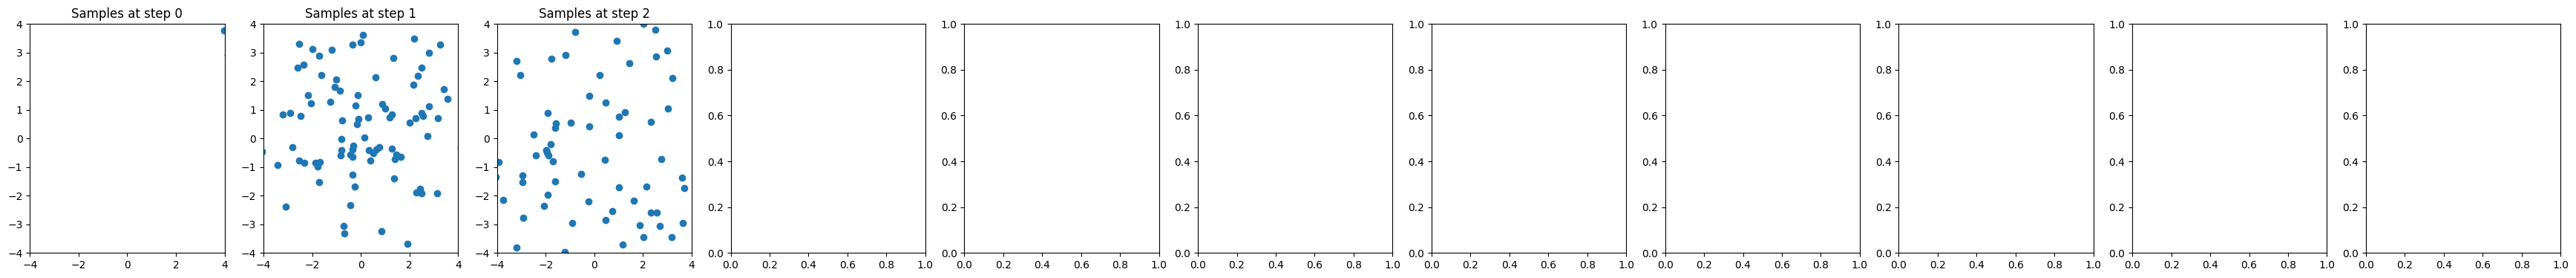

In [236]:
import matplotlib.pyplot as plt

# Sample 10 times 
fig, axs = plt.subplots(1, 11, figsize=(44, 4))
if len(samples) < 11:
    for k in range(len(samples)):
        current_samples = samples[k].flatten(1).detach().cpu().numpy()
        axs[k].scatter(current_samples[:,0], current_samples[:,1])
        axs[k].set_xlim(-4, 4)
        axs[k].set_ylim(-4, 4)
        axs[k].set_title("Samples at step {}".format(k))
else :
    for k in range(10):
        current_samples = samples[len(samples)//10 * k].flatten(1).detach().cpu().numpy()
        axs[k].scatter(current_samples[:,0], current_samples[:,1])
        axs[k].set_xlim(-4, 4)
        axs[k].set_ylim(-4, 4)
        axs[k].set_title("Samples at step {}".format(len(samples)//10 * k))
    current_samples = samples[-1].flatten(1).detach().cpu().numpy()
    axs[-1].scatter(current_samples[:,0], current_samples[:,1])
    axs[-1].set_xlim(-4, 4)
    axs[-1].set_ylim(-4, 4)
    axs[-1].set_title("Samples at step {}".format(len(samples)-1))

In [163]:
print(len(log_prob))

11
